In [ ]:
# A rewrite of the code to make it easier to deal with. 
# We now allow for a multi-grid solver with uneven lengths and different resolutions.
# State vector: [t, ξ, p_2, a_4], var_vec.
# var_vec: Phi, S, Sdot, PhiDot, A.
# 
T = BigFloat;
setprecision(T,256)

# T = Float64;

# --------------------------------------------------------------
#  Struct definition: this holds all variables at a grid point.
# --------------------------------------------------------------

struct PDEVars{T}
    Phi::T
    S::T
    Sdot::T
    Phidot::T
    A::T
    PhiZ::T
    SZ::T
    SdotZ::T
    PhidotZ::T
    AZ::T
    PhiZZ::T
    SZZ::T
    SdotZZ::T
    PhidotZZ::T
    AZZ::T
    z::T
    LN::T
    t::T
    X::T
    p2::T
    a4::T
    DS0::T
    DS1::T
    DS2::T
    DS3::T
    DS4::T
end

using Plots
using Parameters: @unpack

include("cheb.jl")
include("Equation expressions/ODECoeffExpr.jl");
include("Equation expressions/CosmoS0Expr.jl");
include("Equation expressions/CosmoTimeStepExpr.jl");
include("Equation expressions/CosmoConstrExpr.jl");
include("solvers.jl")

#Properties of this simulation:

global const H = T(3.);
global const Om = T(4.);
global const tstar = 1;
global const M = T(1.);
global zAH = T(1/2);

global const z_boundaries = [zero(T), T(0.1), T(0.3), T(0.5), T(0.55)]; #Boundaries of grid domains.
global const domain_sizes = [10, 15, 15, 10]; #sizes of all domains.
global const Ndom = length(domain_sizes);
global const N = sum(domain_sizes);

global const zero_var = [zeros(T,n) for n in domain_sizes]; #Helpful for getting arrays of the right shape

diff2_mats, diff1_mats, grids, damp_mats = MultiGridChebyshev(z_boundaries,domain_sizes);

Vfun(x) = ( -576. - 288. * x^2 - 64. * x^4 + 22. * x^6 - x^8) / 192.;
DV(x) = - x * (144. + 64. * x^2 - 33. * x^4 + 2. * x^6) / 48.;


In [60]:
init_guess = [copy(zero_var) for var in 1:NVar];
Var = copy(init_guess);

In [61]:
init_params = [T(-3), T(0.), 0, -T(100.)];
init_guess = [copy(zero_var) for var in 1:NVar];


In [62]:

Var = copy(init_guess);
VarZ,VarZZ = ComputeDerivatives(Var);

for ii in 1:500
    Var[ind_s] = LinearSolveODE(1, init_params, Var, VarZ, VarZZ);
    VarZ[ind_s] = ComputeSingleDerivative(Var[ind_s]);
    VarZZ[ind_s] = ComputeSingleDerivative(Var[ind_s], deg=2);

    Var[ind_sdot] = LinearSolveODE(2, init_params, Var, VarZ, VarZZ);
    VarZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot]);
    VarZZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot], deg=2);

    newX = CorrectXi(init_params, Var);
    print("\rX = $newX");
    flush(stdout);

    init_params[ind_X] = newX;
end

X = 1.0184507965092028621348467727022113294536922460904300595054579986906308194890969

In [63]:
InitVar = ComputeBulk(init_params, Var);

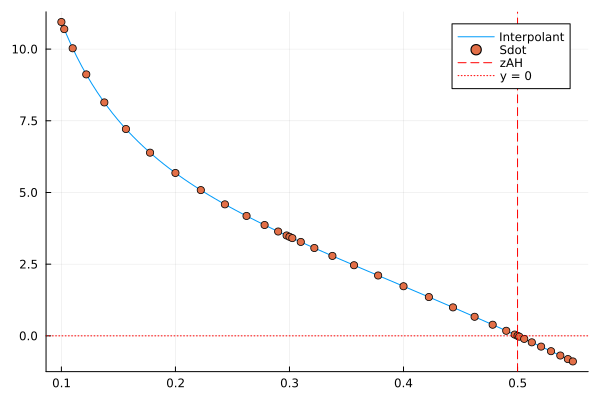

In [64]:
fig = PlotSdot(init_params,Var);
display(fig)

In [ ]:
dt = T(.00005);


outfile = [];
monitorfile = [];

VarFinal, XFinal, a4Final = Evolve(init_params,InitVar, 2, dt, 100, outfile, monitorfile);

# close(outfile);
# close(monitorfile);

◐ time = -2.557, constraint violation = 0.001    Time: 0:04:12mm

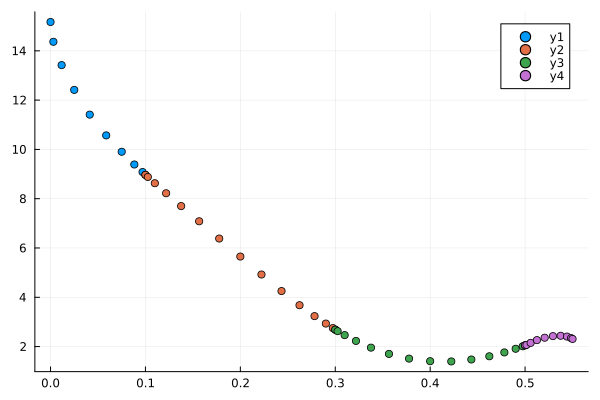

In [45]:
scatter(grids,outfile[end][1])

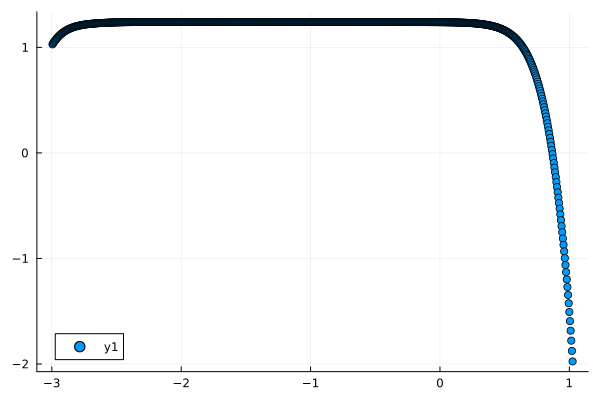

In [46]:
scatter([x[1] for x in monitorfile],[x[2] for x in monitorfile])

In [47]:
length(outfile)

805

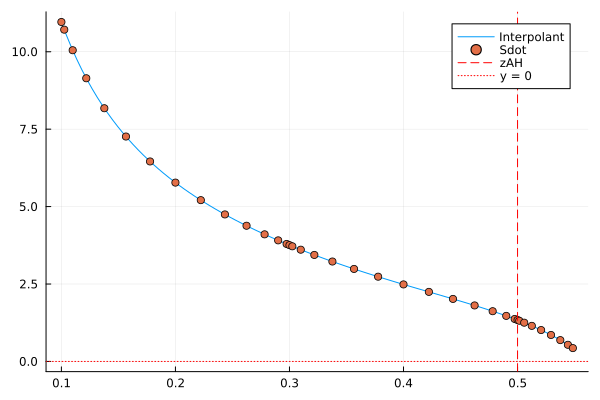

In [48]:
fig = PlotSdot(init_params,outfile[790]);
display(fig)